# Failed Attempt of the Nonlinear Buckling Analysis of the uCRM-9

***

This notebook shows how my PhD journey on the use of nonlinear structural stability analysis for aeroelastic optimization started and provides a justification for the series of notebooks published in this repository.

I started my PhD in March 2021 and after a few months of literature review, I thought I had found an interesting gap in the literature on aeroelastic optimizations. All optimization frameworks I had found in the literature employed linear buckling analysis to assess the structural stability of the optimized designs. However, [one of these papers](https://arc.aiaa.org/doi/epdf/10.2514/1.J054244) mentioned the following: _"only linear buckling is considered here: stiffened panels may continue to carry load beyond their linear buckling point, and so these estimates may be overly conservative relative to a nonlinear buckling result"_. This statement lit a spark in my mind and I thought: why not use nonlinear buckling to assess structural stability in aeroelastic optimization?

However this spark was based on my very naive understanding of buckling. Back then I was everything but an expert of buckling, and I thought of it as a binary phenomenon: either the structure has not buckled and thus has not failed, or the structure has buckled and consequently has failed. It took me a couple of years to understand that buckling is actually a more complex phenomenon with several facets, and I guess I'm still in the process of understanding it at a deeper level. Today I even refrain from using the term "buckling" and prefer to use the expression "structural stability" instead, as I think that the common accepted meaning of buckling is misleading at best. Anyway, this is a topic for another notebook.

At the same time of when I developed my idea of using nonlinear buckling for aeroelastic optimization, I also found out that some kind of nonlinear buckling method was available in MSC Nastran, the FE code that my industrial supervisors were keen for me to use, being it the standard for aeroelastic analysis in industry. Consequently, I thought that I had found a perfect match: I had an idea and a tool to implement it. I only needed a Nastran wingbox model to plug this promising nonlinear buckling method into, which I found in the [uCRM-9](https://arc.aiaa.org/doi/epdf/10.2514/1.J056603), a flexible version of NASA's [Common Research Model](https://commonresearchmodel.larc.nasa.gov/) (CRM) developed by the MDO Lab of University of Michigan. At that point, I thought I was ready to produce some novel results without too much effort. My level of naivety was evidently over the top and it must also have been pretty contagious, as I convinced my five supervisors that this was a good idea and we even submitted an abstract for [IFASD 2022](https://eventos.uc3m.es/54044/detail/international-forum-on-aeroelasticity-and-structural-dynamics-2022-.html), the most important conference on aeroelasticity, promising to present a fantastic approach to aeroelastic optimization based on nonlinear buckling analysis.

The envisioned work for this paper was based on my very limited understanding of buckling and of the supposedly amazing nonlinear buckling method of Nastran. My idea was to calculate the buckling load of the uCRM-9 predicted by the linear analysis, which is based on the undeformed geometry of the structure, and then compare it with the buckling load predicted by the nonlinear buckling method, which from what I understood was based on the deformed geometry at the applied load. In my mind, this calculation of the buckling load based on the deformed geometry was supposed to be more accurate and less conservative than the linear buckling prediction. If I could show that the nonlinear buckling method predicted a buckling load higher than the linear buckling analysis, I would have had a proof of the potential of using nonlinear buckling for aeroelastic optimization. Easy peasy, right?

Except that Nastran's nonlinear buckling method did not work as expected and it did not seem to produce sensible results. Consequently, I had to withdraw my abstract, which in the meantime had been accepted for the conference, and take a reality check on my fantasy of producing novel results with little effort. I was then forced to do the only reasonable thing to really understand how to use nonlinear buckling in an aeroelastic optimization: restarting my journey from the fundamentals of buckling and nonilnear analysis, thus looking at the simplest problem in the field, the Euler's column. This led to the development of my [first notebook](01_Buckling_Analysis_of_Euler_Column.ipynb), and of the many others that followed where I gradually increased the complexity of the problem I looked at.

Before moving on to my failed attempt of the nonlinear buckling analysis of the uCRM-9, I would just like to share a few lessons that I learned from this experience.
- Doing a PhD in engineering is hard. You have to produce novel results in a niche of a niche of a niche. It is challenging to find a problem that is novel in the ocean of research being carried out over the world. It is even more challenging to find an idea to tackle such problem. And it is even more challenging to make such idea work. Furthermore, the newer the idea, the more challenging it is to make it work. In this context a PhD candidate should expect to be common to fail many times before succeding and should have a supportive environment around them to keep going. I was lucky enough to have such environment and I am very grateful for that. However I shouldn't feel lucky about this, as it should be the norm.
- Mastering the fundamentals of a problem is essential to try something novel. And building knowledge by increasing the complexity one step at a time is key to success. You can't run before you can walk.
- Building knowledge by gradually increasing complexity takes time. A shitload of time. And once a single person has invested such amount of time in building knowledge, it would be good for the entire research community to have an efficient knowledge transfer tool. This is one of the main reasons why I decided to develop these notebooks and share them on GitHub. I hope that my research will be usfeul to someone else and that someone else will be able to learn in a few weeks what took me a few years to learn.

On to how everything started now: my failed attempt of the nonlinear buckling analysis of the uCRM-9!

* [Setup of the numerical model](#numerical-model)
* [Linear buckling analysis](#linear-buckling)
* [Nonlinear buckling method](#nonlinear-buckling)
* [Conclusion](#conclusion)

## Setup of the numerical model <a name="numerical-model"></a>

***

The uCRM-9 is a flexible version of NASA's CRM ([Vassberg et al. 2008](https://arc.aiaa.org/doi/abs/10.2514/6.2008-6919)) developed by [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603). The Nastran structural mesh files for the aluminum wingbox structure including material properties based on a smeared stiffness blade-stiffened panel approach can be found on [this Mendeley Data page](https://data.mendeley.com/datasets/gpk4zn73xn/1). Also the aerodynamic loads for the nominal 1g cruise and the Nastran run files for linear static analysis (SOL 101) and modal analysis (SOL 103) are given in the same place. All data is provided in SI units, that is to say using the _meter - newton - pascal - kg_ combination.

To create, manipulate, run and analyze the results of Nastran models in a jupyter notebook environment, we are going to rely on the [`pyNastran`](https://github.com/SteveDoyle2/pyNastran) package. For the case of the uCRM-9 model, we start by creating an object of the `BDF` class, which represents a Nastran input file (bdf file).

In [1]:
from pyNastran.bdf.bdf import BDF  # import BDF class from pyNastran

ucrm9_bdf = BDF(debug=None)  # create an empty BDF object

Then we create the case control deck requesting not to print the bulk data to the f06 file and to store the displacements and applied loads only in the op2 file.

In [2]:
ucrm9_bdf.create_subcases(0)  # initialize case control deck
ucrm9_bdf.case_control_deck.subcases[0].add('ECHO', 'NONE', [], 'STRING-type')  # do not print bulk data to the f06 file
ucrm9_bdf.case_control_deck.subcases[0].add_result_type('DISPLACEMENT', 'ALL', ['PLOT'])  # store displacement data of all nodes in the op2 file
ucrm9_bdf.case_control_deck.subcases[0].add_result_type('OLOAD', 'ALL', ['PLOT'])  # store form and type of applied load vector in the op2 file

subcase=0 already exists...skipping


Now we need to import the structural mesh and the 1g aerodynamic loads using the bdf files provided by [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603). We do this by using the `add_include_file` method of the `BDF` class.

In [3]:
import os  # import os module to handle file paths

resources_directory_path = os.path.join(os.pardir, os.pardir, 'resources')  # define path to the resources directory
ucrm9_bdf.add_include_file(os.path.join(resources_directory_path, 'uCRM-9_wingbox_coarse.bdf'))  # include the uCRM-9 structural mesh
ucrm9_bdf.add_include_file(os.path.join(resources_directory_path, 'uCRM-9_aero_forces_1.0g_coarse.bdf'))  # include 1g aerodynamic forces

`uCRM-9_wingbox_coarse.bdf` contains the `SPC` cards defining the single point constraint applied to the model, while `uCRM-9_aero_forces_1.0g_coarse.bdf` contains the `FORCE` cards defining the aerodynamic forces applied at each node. Each type of cards has a unique id, which is used to aggregate the cards belonging to the same constraint or applied load. We record the ids of the `SPC` and `FORCE` cards and we add the former to the case control deck to indicate the single point constraint applied in the analysis. 

In [4]:
spc_id = 1  # record the id of the SPC cards
force_id = 1  # record the id of the FORCE cards
ucrm9_bdf.case_control_deck.subcases[0].add_integer_type("SPC", spc_id)  # add the id of the SPC cards to the case control deck

Finally, we add some `PARAM` cards to replicate the settings prescribed in the original run files.

In [5]:
ucrm9_bdf.add_param('AUTOSPC', ['NO'])  # singularities in the stiffness matrix will not be constrained
ucrm9_bdf.add_param('GRDPNT', [1])      # execute grid point weight generator using node with id 1 as reference point
ucrm9_bdf.add_param('K6ROT', [1e5])     # specifies the scaling factor of the penalty stiffness to be added to the normal rotation for CQUAD4 and CTRIA3 elements
ucrm9_bdf.add_param('COUPMASS', [-1])   # causes the generation of lumped mass matrices (which may include torsion inertia for beam elements, and some coupling if there are beam offsets) for the following elements: CBAR, CBEAM, CONROD, CQUAD4, CHEXA, CPENTA, CPYRAM, CQUAD8, CROD, CTETRA, CTRIA3, CTRlA6, CTRIAX6, CTUBE
ucrm9_bdf.add_param('MAXRATIO', [1e7])  # threshold for the ratios of terms on the diagonal of the stiffness matrix to the corresponding terms on the diagonal of the triangular factor above which the matrix will be considered to be nearly singular
ucrm9_bdf.add_param('POST', [1])        # store results in a op2 file
ucrm9_bdf.add_param('WTMASS', [1.])     # the terms of the structural mass matrix are multiplied by the value of WTMASS when they are generated

PARAM     WTMASS      1.

## Linear buckling analysis <a name="linear-buckling"></a>

***

The first step of this study is the calculation of the linear buckling load of the uCRM-9 under the 1g aerodynamic load. The main result of this analysis will be the buckling load factor, $BLF$, that is the factor by which the 1g aerodynamic load need to be increased to reach the buckling load. In this study, we assume that the aircraft load factor ($n=L/W$, where $L$ is the lift and $W$ is the weight of the aircraft) at which the structure buckles, $n_b$, is given by the load factor of the applied load times the buckling load factor. Since the load factor of the 1g aerodynamic load is 1, then we have $n_b=BLF$.

This assumption is far from being correct. In fact, it corresponds to assuming that we can obtain the $x$-g aerodynamic load by scaling the 1g aerodynamic load by a factor $x$. This is not true, as the aerodynamic load is not a linear function of the load factor, and its distribution changes with the deformation of the structure. However, in this study we are not interested in the actual aeroelastic buckling load of the aircraft, but only in comparing the results of the linear and nonlinear buckling analyses, and this approach simplifies the computations for the comparison. Furthermore, the 1g aerodynamic load of the uCRM-9 is supposed to be used together with the gravity load, which we intentionally neglect here to simplify the analysis.

We now need to complete our input file for MSC Nastran's linear buckling solution sequence, SOL 105. We then execute the following steps:
- create a deep copy of the base `BDF` object (in order to preserve the original base `BDF` object and reuse it later);
- assign SOL 105 as solution sequence;
- create first subcase where we apply the 1g aerodynamic load. We do this using the function `create_static_load_subcase` from the `pynastran_utils` module, which contains some useful functions to work with `pyNastran` objects;
- create second subcase where we solve the eigenvalue problem and consequently calculate the buckling load.

In [6]:
from resources import pynastran_utils  # module with useful functions to work with pyNastran objects

# Create deep copy of the initial BDF object and define solution sequence
linear_buckling_bdf = ucrm9_bdf.__deepcopy__({})
linear_buckling_bdf.sol = 105

# Create first subcase for the application of the compression load
load_application_subcase_id = 1  # first subcase id
pynastran_utils.create_static_load_subcase(bdf_object=linear_buckling_bdf, subcase_id=load_application_subcase_id, load_set_id=force_id)  # create subcase

# Create second subcase for the calculation of the buckling load
eigrl_id = force_id + 1  # id of the EIGRL card, used to define a real eigenvalue analysis with the Lanczos method
linear_buckling_bdf.add_eigrl(sid=eigrl_id, v1=0., nd=1)  # calculate only the first positive eigenvalue
eigenvalue_calculation_subcase_id = 2  # second subcase id
linear_buckling_bdf.create_subcases(eigenvalue_calculation_subcase_id)  # create second subcase
linear_buckling_bdf.case_control_deck.subcases[eigenvalue_calculation_subcase_id].add_integer_type('METHOD', eigrl_id)  # add EIGRL card id to case control deck

Finally, we define the directory where we will run the analyses of this notebook and the name of our input bdf file. Then we can call the function `run_analysis` from the `pynastran_utils` module, which we imported earlier. `run_analysis` creates the analysis directory if it doesn't exist alreardy, writes the input `BDF` object to a bdf file and runs the analysis with Nastran.

In [7]:
# Define name of analysis directory
analysis_directory_name = '00_Failed_Attempt_of_the_Nonlinear_Buckling_Analysis_of_the_uCRM-9'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)

# Define input name and run analysis
input_name = 'linear_buckling'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=linear_buckling_bdf, filename=input_name, run_flag=False)

Nastran job linear_buckling.bdf completed
Wall time: 18.0 s


Once the analysis is done we read the results from the op2 file and we print the buckling load factor.

In [8]:
from pyNastran.op2.op2 import read_op2  # import function to read op2 files

# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_name + '.op2')
linear_buckling_op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)

# Find eigenvalue and print buckling load factor to screen
buckling_load_factor = linear_buckling_op2.eigenvectors[eigenvalue_calculation_subcase_id].eigr  # retrieve eigenvalue from the OP2 object
print(f"BLF = {buckling_load_factor:.2f}")

BLF = 2.95


Our analysis predicts that the structure buckles at a load factor $n_b=2.95$ g. Let's plot the associated buckling mode using the function `plot_buckling_mode` from the `pynastran_utils` module.

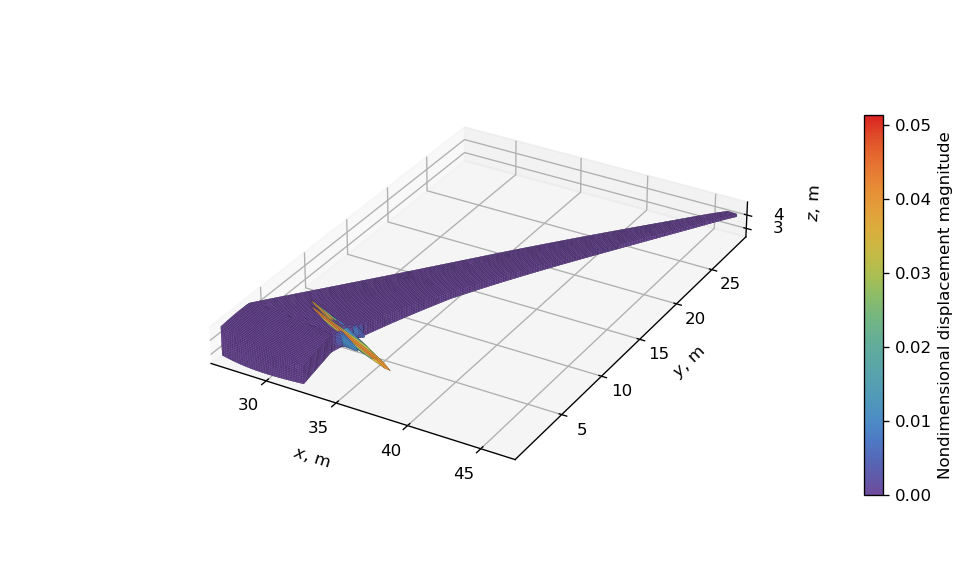

In [9]:
# Enable interactive plots
%matplotlib widget

import matplotlib.pyplot as plt  # import plotting library

# Define function to adjust axes and colorbar of 3D plots
def adjust_axes_and_colorbar(axes, colorbar, figure):
    axes.locator_params(axis="x", nbins=7)  # set number of bins along x-axis
    axes.locator_params(axis="z", nbins=2)  # set number of bins along z-axis
    axes.xaxis.labelpad = 10  # increase distance of x-axis's label to y-axis
    axes.yaxis.labelpad = 10  # increase distance of y-axis's label to z-axis
    colorbar.ax.set_position(colorbar.ax.get_position().shrunk(1.0, .66))  # decrease colorbar size
    colorbar.ax.set_position(colorbar.ax.get_position().translated(.05, .14))  # move colorbar upwards and to the right
    figure.set_figwidth(8)  # increase figure width

plt.rcParams['figure.dpi'] = 120  # set figure resolution
fig, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=linear_buckling_op2, subcase_id=eigenvalue_calculation_subcase_id, displacement_amplification_factor=100,
                                                   length_unit='m')
adjust_axes_and_colorbar(ax, cbar, fig)  # adjust axes and colorbar
plt.show()  # show figure

The critical buckling mode predicted by SOL 105 involves unexpectedly the rear spar of the wingbox instead of the top skin.

## Nonlinear buckling method <a name="nonlinear-buckling"></a>

***

The following step of this investigation consists in calculating the buckling load predicted by Nastran's nonlinear buckling method. This method is available in the nonlinear solution sequence, SOL 106, and it was introduced by [Lee & Herting (1985)](https://onlinelibrary.wiley.com/doi/pdf/10.1002/nme.1620211016). The approach is based on the assumption that the tangent stiffness matrix vary linearly in a small range close to the last two converged solutions of the nonlinear analysis. If a critical point exists sufficiently close to the last converged solution, then the tangent stiffness matrix at such point can be expressed as:

$$\bm{K}_{cr}=\bm{K}_n+\lambda\bm{\Delta K},$$

where $\bm{\Delta K}=\bm{K}_n-\bm{K}_{n-1}$ is the differential stiffness matrix based on the last two converged solutions $n$ and $n-1$ and $\lambda$ is a proportionality factor.

Since the tangent stiffness matrix is singular at the critical point, we can formulate the following eigenvalue problem:

$$\left(\bm{K}_n+\lambda\bm{\Delta K}\right)\bm{\phi}=\bm{0},$$

where $\lambda$ and $\bm{\phi}$ respectively represent the eigenvalues and the eigenvectors related to the critical displacements $\bm{U}_{cr}$:

$$\bm{U}_{cr}=\bm{U}_n+\lambda\bm{\Delta U},$$

with $\bm{\Delta U}=\bm{U}_n-\bm{U}_{n-1}$. Nastran calculates the vector of critical buckling loads $\bm{P}_{cr}$ as:

$$\bm{P}_{cr}=\bm{P}_n+\alpha\bm{\Delta P},$$

where $\bm{P}_n$ is the vector of the applied loads, $\alpha$ is the critical buckling factor and $\bm{\Delta P}$ is the last load increment vector applied in the nonlinear analysis. $\alpha$ and $\lambda$ are related by the following expression:

$$\alpha=\frac{\lambda\bm{\Delta U}^\intercal\left(\bm{K}_n+\frac{1}{2}\lambda\bm{\Delta K}\right)\bm{\Delta U}}{\bm{\Delta U}^\intercal\bm{\Delta P}}.$$

The load factor at which the structure buckles is calculated as follows:

$$n_b=\frac{\left|\bm{P}_{cr}\right|}{\left|\bm{P}_n\right|},$$

where $\left|\cdot\right|$ represents the norm of the vector. This is computed by summing the forces on all nodes along each axis and by taking the Euclidean norm on the summed quantities.

The idea is that by estimating the critical buckling load using the information from the last two converged solutions of the nonlinear analysis, which take into account the deformation of the structure at the applied load, we can obtain a more accurate prediction of the buckling load than the one obtained by the linear analysis. Besides this, we expect to find a load factor at which the structure buckles $n_b<2.95$ g, as the linear analysis is known to be conservative.

We are going to test the nonlinear buckling method with two different applied loads: the 1 g and the 2.5 g aerodynamic laod. Following our assumption, we are going to obtain the 2.5 g load by simply scaling up the 1g load. Since the 2.5 g aerodynamic load should be closer to the actual buckling load, we expect the nonlinear prediction at this load to be more accurate than the one at 1 g. Besides this, it appears reasonable to suppose that the prediction becomes less conservative as we approach the true buckling load.

We now need to complete our input for the nonlinear analysis. We execute the following steps:
- create a deep copy of the initial `BDF` object and define solution sequence;
- add `LOAD` card to enable scaling of the applied load and define the first subcase;
- define the paramaters for the execution of the nonlinear buckling method.

In [10]:
# Create deep copy of the initial BDF object and define solution sequence
nonlinear_buckling_bdf = ucrm9_bdf.__deepcopy__({})
nonlinear_buckling_bdf.sol = 106

# Creat load set and corresponding subcase
load_set_id = eigrl_id + 1  # id of the LOAD card
nonlinear_buckling_bdf.add_load(sid=load_set_id, scale=1., scale_factors=[1.], load_ids=[force_id])  # create load set of the 1g aerodynamic load
pynastran_utils.create_static_load_subcase(bdf_object=nonlinear_buckling_bdf, subcase_id=load_application_subcase_id, load_set_id=load_set_id)  # create subcase

# Define execution of nonlinear buckling method
nonlinear_buckling_bdf.add_param('LGDISP', [1])  # assume all nonlinear structural element types that have a large displacement capability to have large displacement effects
nonlinear_buckling_bdf.add_param('BUCKLE', [2])  # request nonlinear buckling method in a SOL 106 cold start run
nonlinear_buckling_bdf.add_eigrl(sid=eigrl_id, v1=0., nd=1)  # define eigenvalue calculaiton with Lanczos method and calculate only the first positive eigenvalue
nonlinear_buckling_bdf.case_control_deck.subcases[load_application_subcase_id].add_integer_type('METHOD', eigrl_id)  # add EIGRL card id to case control deck

Then we need to define the nonlinear solver. Inspired by the shallow cylindrical shell snap-through example from the *MSC Nastran Demontration Problems Guide - Implicit Nonlinear*, we choose to use the arc-length solver. We do this by adding two cards to the `BDF` object: the `NLPARM` and the `NLPCI` card. The former defines the general parameters of the nonlinear iteration strategy, while the latter defines the parameters of the arc-length method. The parameters of two cards are based on the mentioned example and summarized below:
- NLPARM
  * `ninc=100` to set the initial load increment $\Delta\mu^1 = 1/NINC$ to 1% of the total applied load;
  * `kmethod='ITER'` and `kstep=-1` to update the stiffness matrix at every iteration. The value of -1 means that the stiffness matrix is forced to be updated between the convergence of a load increment and the start of the next load increment. We don't set `KSTEP` to 1 (corresponding to no update between load increments) because in this way the solver would ignore the displacement error in the convergence criteria (see the explanation of the NLPARM card on the *MSC Nastran Quick Reference Guide* for more details);
  * `max_iter=25` to set the maximum number of iterations for each load increment;
  * `conv='PUV'` to select convergence based on the load equilibrium and the displacement errors with vector component method (convergence checking is performed on the maximum vector component of all components in the model);
  * `int_out='YES'` to process the output for every converged load increment;
  * `eps_p=1e-3` and `eps_u=1e-3` to set the error tolerance for the load and the displacement criterion, respectively;
  * `max_bisect=10` to set the maximum number of bisections allowed for each load increment.
- NLPCI
  * `Type='CRIS'` to set Crisfield constraint type;
  * `minalr=.01` and `maxalr=1.0001` to set the minimum and maximum allowable arc-length adjustment ratio between increments, where $MINALR \leq\frac{\Delta l_{new}}{\Delta l_{old}}\leq MAXALR$ and $\frac{\Delta l_{new}}{\Delta l_{old}}$ is the adjument ratio of the arc-length;
  * `desiter=5` to set the desired number of iterations for convergence, which is used to calculate the arc-length for the next increment $\Delta l_{new}=\Delta l_{old}\sqrt{DESITER/I_{max}}$, where $I_{max}$ represents the number of iterations required for convergence in the previous load increment;
  * `mxinc=1000` to set the maximum number of controlled increment steps allowed within a subcase.

In [11]:
nlparm_id = 1  # id of the NLPARM and NLPCI cards
nonlinear_buckling_bdf.add_nlparm(nlparm_id, ninc=100, kmethod='ITER', kstep=-1, max_iter=25, conv='PUV', int_out='YES', eps_p=1e-3, eps_u=1e-3, max_bisect=10)
nonlinear_buckling_bdf.add_nlpci(nlparm_id, Type='CRIS', minalr=.01, maxalr=1.0001, desiter=5, mxinc=1000)
nonlinear_buckling_bdf.case_control_deck.subcases[0].add_integer_type('NLPARM', nlparm_id)  # add NLPARM card id to case control deck

Finally, the last step before running the nonlinear analysis consists in adding a command to change all `CQUADR` cards into `CQUAD4` cards, as SOL 106 cannot work with the former type of elements.

In [12]:
nonlinear_buckling_bdf.system_command_lines[0:0] = ['NASTRAN QRMETH=3']


Let's define the load factors corresponding to the 1 g and 2.5 g aerodynamic load, run the analyses, print the resulting $n_b$ and plot the associated buckling modes.

Nastran job nonlinear_buckling_1_0g.bdf completed
Wall time: 1099.0 s


n = 1.0 g --> n_b = 1.17 g
Buckling mode:


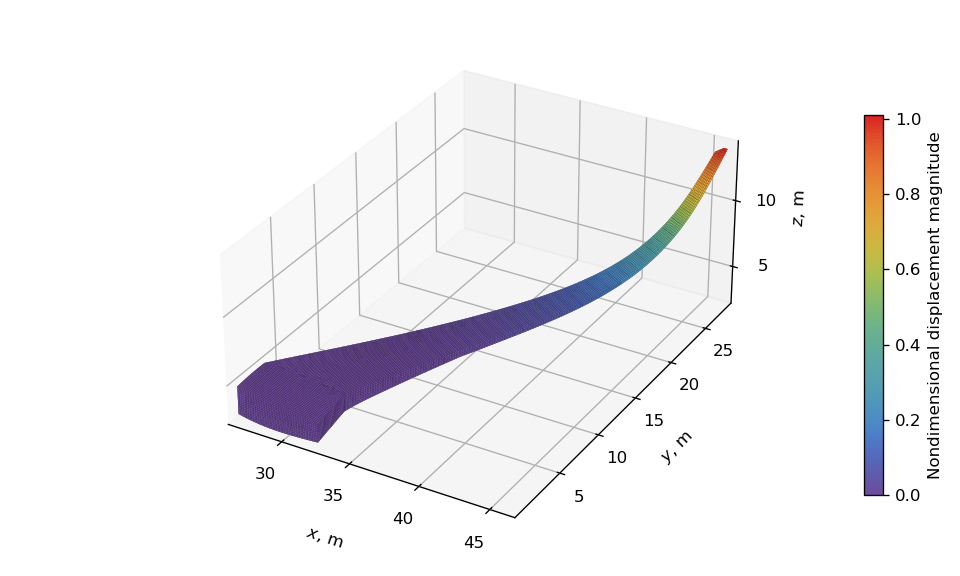

Nastran job nonlinear_buckling_2_5g.bdf completed
Wall time: 1186.0 s


n = 2.5 g --> n_b = 2.93 g
Buckling mode:


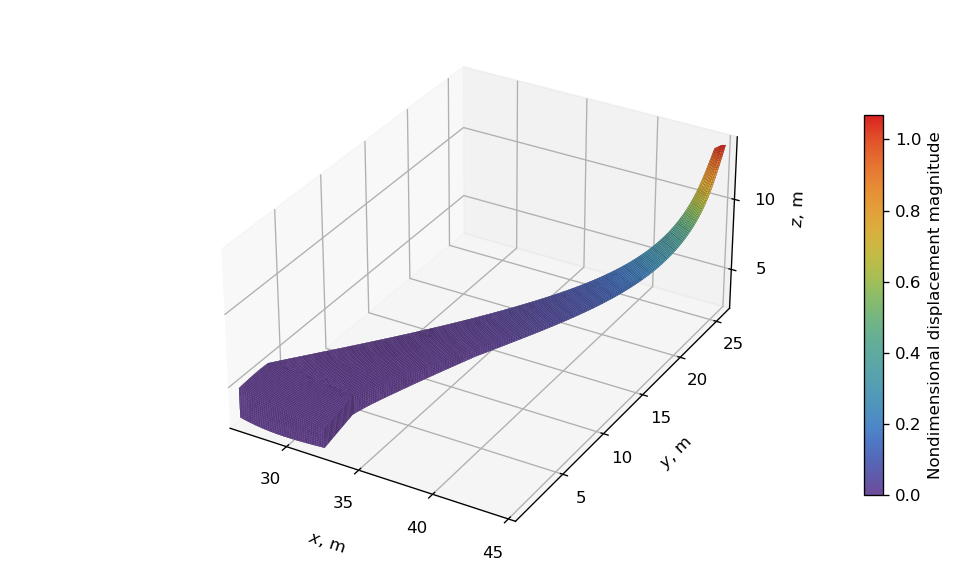

In [13]:
import numpy as np  # import numpy module

applied_load_factors = [1., 2.5]  # define applied load factors

# Iterate over applied load factors to run analysis and plot results
for applied_load_factor in applied_load_factors:
    nonlinear_buckling_bdf.load_combinations[load_set_id][0].scale_factors[0] = applied_load_factor  # update applied load factor
    input_name = f"nonlinear_buckling_{applied_load_factor:.1f}g".replace('.', '_')  # define input name
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=nonlinear_buckling_bdf, filename=input_name, run_flag=False)  # run analysis
    nonlinear_buckling_op2 = read_op2(op2_filename=os.path.join(analysis_directory_path, input_name + '.op2'), load_geometry=True, debug=None)  # read op2 file
    f06_filepath = os.path.join(analysis_directory_path, input_name + '.f06')  # define f06 file path
    nonlinear_buckling_load_vectors, _ = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=f06_filepath, op2_object=nonlinear_buckling_op2)  # read nonlinear buckling load from f06 file
    load_vectors_subcase_key = next(subcase_id for subcase_id in nonlinear_buckling_op2.load_vectors if hasattr(nonlinear_buckling_op2.load_vectors[subcase_id], 'lftsfqs'))  # find subcase id with valid load vectors
    applied_load_vector = nonlinear_buckling_op2.load_vectors[load_vectors_subcase_key].data[-1, :, :]  # retrieve applied load vector
    blf = np.linalg.norm(np.sum(nonlinear_buckling_load_vectors[0, :, 0:3], axis=0))/np.linalg.norm(np.sum(applied_load_vector[:, 0:3], axis=0))  # calculate buckling load factor as the ratio between the norm of the nonlinear buckling load vector and the norm of the applied load vector
    n_b = applied_load_factor*blf  # calculate load factor at which buckling occurs
    print(f"n = {applied_load_factor:.1f} g --> n_b = {n_b:.2f} g")
    print("Buckling mode:")
    eigenvectors_subcase_key = next(subcase_id for subcase_id in nonlinear_buckling_op2.eigenvectors)  # find subcase key corresponding to the eigenvectors
    fig, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=nonlinear_buckling_op2, subcase_id=eigenvectors_subcase_key, displacement_amplification_factor=10,
                                                       length_unit='m')  # plot buckling mode
    adjust_axes_and_colorbar(ax, cbar, fig)  # adjust axes and colorbar
    plt.show()  # show figure

What the hell is happening here? Why the nonlinear buckling method predicts $n_b=1.17$ g for an applied load factor of 1 g and $n_b=2.93$ g for an applied load factor of 2.5 g? And what are those strange buckling modes? These results do not seem to make any sense.

We repeat the analysis applying a load factor equal to the load factor of buckling predicted by the linear analysis.

Nastran job nonlinear_buckling_2_9g.bdf completed
Wall time: 1108.0 s


n = 2.95 g --> n_b = 3.15 g
Buckling mode:


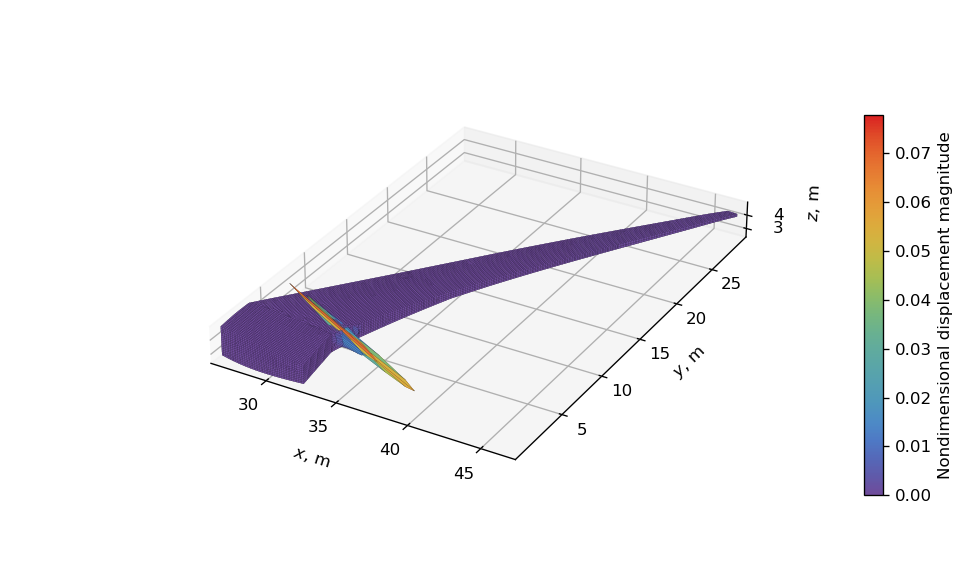

In [14]:
applied_load_factor = buckling_load_factor  # define applied load factor
nonlinear_buckling_bdf.load_combinations[load_set_id][0].scale_factors[0] = applied_load_factor  # update applied load factor
input_name = f"nonlinear_buckling_{applied_load_factor:.1f}g".replace('.', '_')  # define input name
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=nonlinear_buckling_bdf, filename=input_name, run_flag=False)  # run analysis
nonlinear_buckling_op2 = read_op2(op2_filename=os.path.join(analysis_directory_path, input_name + '.op2'), load_geometry=True, debug=None)  # read op2 file
f06_filepath = os.path.join(analysis_directory_path, input_name + '.f06')  # define f06 file path
nonlinear_buckling_load_vectors, _ = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=f06_filepath, op2_object=nonlinear_buckling_op2)  # read nonlinear buckling load from f06 file
load_vectors_subcase_key = next(subcase_id for subcase_id in nonlinear_buckling_op2.load_vectors if hasattr(nonlinear_buckling_op2.load_vectors[subcase_id], 'lftsfqs'))  # find subcase id with valid load vectors
applied_load_vector = nonlinear_buckling_op2.load_vectors[load_vectors_subcase_key].data[-1, :, :]  # retrieve applied load vector
blf = np.linalg.norm(np.sum(nonlinear_buckling_load_vectors[0, :, 0:3], axis=0))/np.linalg.norm(np.sum(applied_load_vector[:, 0:3], axis=0))  # calculate buckling load factor
n_b = applied_load_factor*blf  # calculate load factor at which buckling occurs
print(f"n = {applied_load_factor:.2f} g --> n_b = {n_b:.2f} g")
print("Buckling mode:")
eigenvectors_subcase_key = next(subcase_id for subcase_id in nonlinear_buckling_op2.eigenvectors)  # find subcase key corresponding to the eigenvectors
fig, ax, cbar = pynastran_utils.plot_buckling_mode(op2_object=nonlinear_buckling_op2, subcase_id=eigenvectors_subcase_key, displacement_amplification_factor=100,
                                                   length_unit='m')  # plot buckling mode
adjust_axes_and_colorbar(ax, cbar, fig)  # adjust axes and colorbar
plt.show()  # show figure

This last result is more in line with our expectations, with a predicted load factor at buckling larger than the one predicted by the linear analysis and a similar buckling mode. However, the sequence of $n_b$ predicted for increasing applied load factors is still not consistent with our expectations. In fact, if SOL 106's nonlinear buckling method was able to increase the accuracy of the prediction of the buckling load as the deformed geometry of the structure gets closer to the one at the buckling load, we would expect the predicted load factors at buckling to be similar and gradually converging to a certain value. This is not the case here, as the predicted load factors at buckling are very different from each other and they seem to always be close to the applied load factor.

This behavior casts some doubts on the reliability of SOL 106's nonlinear buckling method.

## Conclusion <a name="conclusion"></a>

***

In this notebook we have attempted to use MSC Nastran SOL 106's nonlinear buckling method to predict the buckling load of the uCRM-9. We first calculated the load factor at which the structure buckles using the SOL 105's linear buckling analysis and we found $n_b=2.95$ g. Then we used the nonlinear buckling method to predict the buckling load at three different applied load factors: 1 g, 2.5 g and 2.95 g. We found $n_b=1.17$ g for the 1 g load factor, $n_b=2.93$ g for the 2.5 g load factor and $n_b=3.15$ g for the 2.95 g load factor. The buckling mode predicted for the first two analyses does not seem to make any sense, while only the one of the last analysis appears to be physically plausible. Furthermore, the sequence of $n_b$ predicted for increasing applied load factors does not reflect our expectation of the nonlinear buckling method being able to increase the accuracy of its prediction as the deformed geometry of the structure gets closer to the one at the buckling load.

Several other analyses were performed to try to explain these results, but none of them led to a better understanding of the problem, and they are not reported in this notebook. The combination of the complexity of the finite element model employed, the lack of understanding of the nonlinear buckling method and the shallow knowledge of nonlinear analysis in general indicates that this is not the right problem to start with when trying to understand how to use nonlinear buckling in aeroelastic optimization. For this reason, in the [first notebook](01_Buckling_Analysis_of_Euler_Column.ipynb) of this series we are going to look at the simplest possible problem in the field: the Euler's column.